## Accurate Product Demand Forecasting for Favorita Stores

1. Business Understanding

### Project Understanding.
**Background.**
Corporation Favorita, a prominent grocery retailer based in Ecuador, aims to ensure optimal stock levels across its various stores to meet customer demand without overstocking. The marketing and sales teams have provided historical sales data to support this objective.

**Goal.**
The primary goal is to develop machine learning models that accurately forecast product demand across different Favorita stores. This will help in maintaining appropriate inventory levels, reducing stockouts and overstock situations, thereby optimizing sales and customer satisfaction.

**Objectives.**
- Predict Unit Sales: Develop a model to predict the unit sales of products at various Favorita stores.
- Analyze Sales Trends: Examine historical sales data to identify trends, patterns, and factors influencing sales.
- Incorporate External Factors: Consider external factors like promotions, oil prices, holidays, and significant events (e.g., earthquakes) in the model.
- Evaluate Store Performance: Compare sales performance across different stores, regions, and product families.
- Optimize Inventory Management: Use the predictions to improve inventory management and supply chain decisions.

**Business Questions and Hypotheses.**
**Business Questions.**
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.
**Hypotheses**
- Null Hypothesis: Promotions do not have a significant effect on the sales of products.
- Alternative Hypothesis: Promotions have a significant effect on the sales of products.


**Data Description and Sources.**
- train.csv: Historical sales data, including dates, store numbers, product family, on-promotion status, and sales figures.
- test.csv: Test data for predicting sales, with the same features as the training data.
- transaction.csv: Daily transactions per store.
- stores.csv: Metadata for stores, including city, state, type, and cluster.
- oil.csv: Daily oil prices, relevant for the economic context of Ecuador.
- holidays_events.csv: Information on holidays and events, including metadata and transferred dates.
- sample_submission.csv: Sample format for submitting predictions.

## Column description

1. **id**: Unique identifier for each record.
2. **date**: Date of the sales record.
3. **store_nbr**: Unique store number.
4. **family**: Category of the product.
5. **sales**: Number of units sold.
6. **onpromotion**: Number of items on promotion.
7. **year**: Year of the sales record.
8. **month**: Month of the sales record.
9. **week**: Week of the sales record.
10. **day_name**: Day of the week (e.g., Monday, Tuesday).
11. **city**: City where the store is located.
12. **state**: State where the store is located.
13. **type_x**: Type of the store.
14. **cluster**: Cluster/group of the store (similar stores are in the same cluster).
15. **transactions**: Number of transactions recorded in the store on the given date.
16. **dcoilwtico**: Daily oil price in Ecuador.
17. **type_y**: Type of holiday or event.
18. **locale**: Scope of the holiday or event (e.g., national, regional).
19. **locale_name**: Specific location name of the holiday or event.
20. **description**: Description of the holiday or event.
21. **transferred**: Indicator if the holiday or event was transferred to another date.



2. Data understanding

#### Importation of Necessary packages

In [12]:
#Import packages
import pyodbc    
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings 

warnings.filterwarnings('ignore')

#### Loading the Datasets

Creating a connection by accessing  connection string with the defined environment variables

In [13]:
# Import necessary libraries
from dotenv import dotenv_values
import pyodbc

# Loading environment variables from .env file
environment_variables = dotenv_values('.env')

# Getting the values for the credentials set in the .env file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
# Connecting to the server
try:
    connection = pyodbc.connect(connection_string)
    print("Connection successful")
except Exception as e:
    print(f"Connection failed: {e}")


Connection successful


In [14]:
# Define the SQL query to show specific tables in the database
db_query = """
        SELECT *
        FROM INFORMATION_SCHEMA.TABLES
        WHERE TABLE_SCHEMA = 'dbo'
        """
# Read data from the SQL query result into a DataFrame using the established database connection
schema_df = pd.read_sql(db_query, connection)

#  Check whether data has been retrieved successfully to confirm successful connection to database
try:
    schema_df = pd.read_sql(db_query, connection)    
    print("Data retrieved successfully")
    print()
    print(schema_df)    
except Exception as e:
    print("Failed to retrieve data:", e)

Data retrieved successfully

  TABLE_CATALOG TABLE_SCHEMA       TABLE_NAME  TABLE_TYPE
0         dapDB          dbo  holidays_events  BASE TABLE
1         dapDB          dbo              oil  BASE TABLE
2         dapDB          dbo           stores  BASE TABLE


In [15]:
# Define the SQL query to show specific tables in the database
db_query = """
        SELECT *
        FROM stores        
        """
# Read data from the SQL query result into a DataFrame 
df_stores = pd.read_sql(db_query, connection)

# Display the DataFrame
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [16]:
# Define the SQL query to show specific tables in the database
db_query = """
        SELECT *
        FROM oil        
        """
# Read data from the SQL query result into a DataFrame using the established database connection
df_oil = pd.read_sql(db_query, connection)

# Display the DataFrame
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [17]:
# Define the SQL query to show specific tables in the database
db_query = """
        SELECT *
        FROM holidays_events        
        """
# Read data from the SQL query result into a DataFrame
df_holidays = pd.read_sql(db_query, connection)

# Display the DataFrame
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Loading the othe datasets

In [18]:
#loading train_csv
train_data =pd.read_csv("C:/Users/USER/OneDrive/Desktop/sprint-Lpp3/Notebook/train.csv")
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [19]:
#loading test dataset
test_data = pd.read_csv("C:/Users/USER/OneDrive/Desktop/sprint-Lpp3/Notebook/test.csv")
test_data

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [20]:
#loading transaction csv
tn_data = pd.read_csv("C:/Users/USER/OneDrive/Desktop/sprint-Lpp3/Notebook/transactions.csv")
tn_data

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [21]:
#A look at the submission csv
ss_data = pd.read_csv("C:/Users/USER/OneDrive/Desktop/sprint-Lpp3/Notebook/sample_submission.csv")
ss_data

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


### EXPLORATORY DATA ANALYSIS

Data Quality Assessment

In [22]:
#gettng to know the data we are dealing with
print("="*50)
print("First Five rows ","\n")
print(df_oil.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df_oil.info(),"\n")

print("="*50)
print("Describe the Dataset","\n")
print(df_oil.describe().T,"\n")

print("="*50)
print("Null Values t ","\n")
print(df_oil.isnull().sum(),"\n")

print("="*50)
print(" Shape of the Dataset","\n")
print(df_oil.shape,"\n")

First Five rows  

         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02   93.139999
2  2013-01-03   92.970001
3  2013-01-04   93.120003
4  2013-01-07   93.199997 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None 

Describe the Dataset 

             count       mean        std        min        25%        50%  \
dcoilwtico  1175.0  67.714366  25.630476  26.190001  46.405001  53.189999   

              75%         max  
dcoilwtico  95.66  110.620003   

Null Values t  

date           0
dcoilwtico    43
dtype: int64 

 Shape of the Dataset 

(1218, 2) 



In [23]:
#gettng to know the data we are dealing with
print("="*50)
print("First Five rows ","\n")
print(df_stores.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df_stores.info(),"\n")

print("="*50)
print("Describe the Dataset","\n")
print(df_stores.describe().T,"\n")

print("="*50)
print("Null Values t ","\n")
print(df_stores.isnull().sum(),"\n")

print("="*50)
print(" Shape of the Dataset","\n")
print(df_stores.shape,"\n")

First Five rows  

   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None 

Describe the Dataset 

           count       mean        std  min    25%  

In [24]:
#gettng to know the data we are dealing with
print("="*50)
print("First Five rows ","\n")
print(df_holidays.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df_holidays.info(),"\n")

print("="*50)
print("Describe the Dataset","\n")
print(df_holidays.describe().T,"\n")

print("="*50)
print("Null Values t ","\n")
print(df_holidays.isnull().sum(),"\n")

print("="*50)
print(" Shape of the Dataset","\n")
print(df_holidays.shape,"\n")

First Five rows  

         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False   

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 no

In [25]:
#gettng to know the data we are dealing with
print("="*50)
print("First Five rows ","\n")
print(train_data.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(train_data.info(),"\n")

print("="*50)
print("Describe the Dataset","\n")
print(train_data.describe().T,"\n")

print("="*50)
print("Null Values t ","\n")
print(train_data.isnull().sum(),"\n")

print("="*50)
print(" Shape of the Dataset","\n")
print(train_data.shape,"\n")

First Five rows  

   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None 

Describe the Dataset 



                 count          mean            std  min        25%  \
id           3000888.0  1.500444e+06  866281.891642  0.0  750221.75   
store_nbr    3000888.0  2.750000e+01      15.585787  1.0      14.00   
sales        3000888.0  3.577757e+02    1101.997721  0.0       0.00   
onpromotion  3000888.0  2.602770e+00      12.218882  0.0       0.00   

                   50%           75%        max  
id           1500443.5  2.250665e+06  3000887.0  
store_nbr         27.5  4.100000e+01       54.0  
sales             11.0  1.958473e+02   124717.0  
onpromotion        0.0  0.000000e+00      741.0   

Null Values t  

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64 

 Shape of the Dataset 

(3000888, 6) 



In [26]:
#gettng to know the data we are dealing with
print("="*50)
print("First Five rows ","\n")
print(tn_data.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(tn_data.info(),"\n")

print("="*50)
print("Describe the Dataset","\n")
print(tn_data.describe().T,"\n")

print("="*50)
print("Null Values t ","\n")
print(tn_data.isnull().sum(),"\n")

print("="*50)
print(" Shape of the Dataset","\n")
print(tn_data.shape,"\n")

First Five rows  

         date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
None 

Describe the Dataset 

                count         mean         std  min     25%     50%     75%  \
store_nbr     83488.0    26.939237   15.608204  1.0    13.0    27.0    40.0   
transactions  83488.0  1694.602158  963.286644  5.0  1046.0  1393.0  2079.0   

                 max  
store_nbr       54.0  
transactions  8359.0   

Null Value

In [27]:
#gettng to know the data we are dealing with
print("="*50)
print("First Five rows ","\n")
print(test_data.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(test_data.info(),"\n")

print("="*50)
print("Describe the Dataset","\n")
print(test_data.describe().T,"\n")

print("="*50)
print("Null Values t ","\n")
print(test_data.isnull().sum(),"\n")

print("="*50)
print(" Shape of the Dataset","\n")
print(test_data.shape,"\n")

First Five rows  

        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None 

Describe the Dataset 

               count          mean          std        min         25%  \
id           28512.0  3.015144e+06  8230.849774 

In [28]:
df_oil.columns

Index(['date', 'dcoilwtico'], dtype='object')

In [29]:
# Fill missing values in the 'dcoilwtico' column using backfill strategy
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='backfill')

**check for duplicates in all datasets**

In [30]:
df_oil.duplicated().sum()

0

In [31]:
df_holidays.duplicated().sum()

0

In [32]:
df_stores.duplicated().sum()

0

In [33]:
test_data.duplicated().sum()

0

In [34]:
train_data.duplicated().sum()

0

In [35]:
tn_data.duplicated().sum()

0

**Insights.**
1. oil dataset has missing values on the 'dcoilwtico' column.
2. The date columns in all dataset is not datetime datatype
3. There are no duplicated rows in the datasets

**changing date columns into datetime datatype**

In [36]:

# Fill missing values in the 'dcoilwtico' column using backfill strategy
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='backfill')
 
# Check for missing values after handling
missing_values_after = df_oil['dcoilwtico'].isnull().sum()
missing_values_after
 

0

In [37]:
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1218 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [38]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [39]:
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [40]:
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [41]:
tn_data['date'] = pd.to_datetime(tn_data['date'])
tn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [42]:
# Extract date features
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.day
train_data['day_of_week'] = train_data['date'].dt.dayofweek
train_data['week'] = train_data['date'].dt.isocalendar().week
train_data['quarter'] = train_data['date'].dt.quarter

merge the datasets

In [43]:
# Merging the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_df with stores_df based on 'store_nbr' column
merged_df1 = train_data.merge(df_stores, on='store_nbr', how='inner')
 
# Merge merged_df1 with transactions_df based on 'date' and 'store_nbr' columns
merged_df2 = merged_df1.merge(tn_data, on=['date', 'store_nbr'], how='inner')
 
# Merge merged_df2 with holidays_events_df based on 'date' column
merged_df3 = merged_df2.merge(df_holidays, on='date', how='inner')
 
# Merge merged_df3 with oil_df based on 'date' column
merged_data = merged_df3.merge(df_oil, on='date', how='inner')
 
# View the first five rows of the merged dataset
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,...,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [44]:
#overview about the data
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,...,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


check for unique values

In [45]:
columns = merged_data.columns
columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week', 'quarter', 'city', 'state',
       'type_x', 'cluster', 'transactions', 'type_y', 'locale', 'locale_name',
       'description', 'transferred', 'dcoilwtico'],
      dtype='object')

In [46]:
#confirm unique values 
for column in columns:
    print(f'{column}')
    print(f'There are {merged_data[column].unique().size} unique values')
    print(f'There are {merged_data[column].unique()}')
    print('='* 50)

id
There are 292545 unique values
There are [  73062   73063   73064 ... 1297887 1297888 1297889]
date
There are 179 unique values
There are <DatetimeArray>
['2013-02-11 00:00:00', '2013-02-12 00:00:00', '2013-04-01 00:00:00',
 '2013-04-12 00:00:00', '2013-04-29 00:00:00', '2013-05-01 00:00:00',
 '2013-05-24 00:00:00', '2013-06-25 00:00:00', '2013-07-03 00:00:00',
 '2013-07-23 00:00:00',
 ...
 '2017-06-23 00:00:00', '2017-07-03 00:00:00', '2017-07-24 00:00:00',
 '2017-07-25 00:00:00', '2017-08-10 00:00:00', '2017-08-11 00:00:00',
 '2017-08-15 00:00:00', '2013-01-01 00:00:00', '2014-01-01 00:00:00',
 '2015-01-01 00:00:00']
Length: 179, dtype: datetime64[ns]
store_nbr
There are 54 unique values
There are [ 1 10 11 12 13 14 15 16 17 18 19  2 23 24 25 26 27 28  3 30 31 32 33 34
 35 37 38 39  4 40 41 43 44 45 46 47 48 49  5 50 51 54  6  7  8  9 36 53
 20 29 21 42 22 52]
family
There are 33 unique values
There are ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBR

In [47]:
# Renaming the columns with the approapriate names
merged_data  = merged_data.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
merged_data .head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,...,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,2013,2,11,0,...,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [48]:
#gettng to know the data we aredealing with after merging
print("="*50)
print("First Five rows ","\n")
print(merged_data.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(merged_data.info(),"\n")

print("="*50)
print("Describe the Dataset","\n")
print(merged_data.describe().T,"\n")

print("="*50)
print("Null Values t ","\n")
print(merged_data.isnull().sum(),"\n")

print("="*50)
print(" Shape of the Dataset","\n")
print(merged_data.shape,"\n")

First Five rows  

      id       date  store_nbr      family  sales  onpromotion  year  month  \
0  73062 2013-02-11          1  AUTOMOTIVE    0.0            0  2013      2   
1  73063 2013-02-11          1   BABY CARE    0.0            0  2013      2   
2  73064 2013-02-11          1      BEAUTY    0.0            0  2013      2   
3  73065 2013-02-11          1   BEVERAGES  172.0            0  2013      2   
4  73066 2013-02-11          1       BOOKS    0.0            0  2013      2   

   day  day_of_week  ...      state  store_type cluster transactions  \
0   11            0  ...  Pichincha           D      13          396   
1   11            0  ...  Pichincha           D      13          396   
2   11            0  ...  Pichincha           D      13          396   
3   11            0  ...  Pichincha           D      13          396   
4   11            0  ...  Pichincha           D      13          396   

  holiday_type    locale  locale_name description transferred dcoilwtico 

UNIVARIATE ANALYSIS

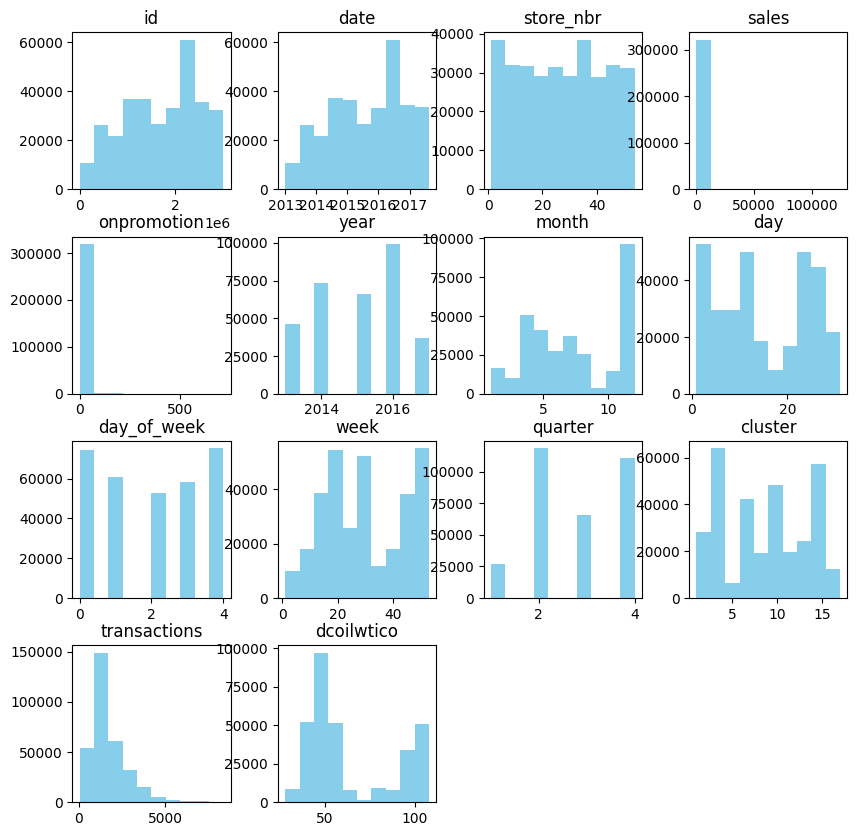

In [49]:
#plot the histograph for the  numerical columns
merged_data.hist(figsize=(10,10), grid=False, color='skyblue')
plt.show()

In [50]:
# Select only numerical columns
numerical_df = merged_data.select_dtypes(include=['number'])
numerical_df


,id,store_nbr,sales,onpromotion,year,month,day,day_of_week,week,quarter,cluster,transactions,dcoilwtico
0,73062,1,0.00000,0,2013,2,11,0,7,1,13,396,97.010002
1,73063,1,0.00000,0,2013,2,11,0,7,1,13,396,97.010002
2,73064,1,0.00000,0,2013,2,11,0,7,1,13,396,97.010002
3,73065,1,172.00000,0,2013,2,11,0,7,1,13,396,97.010002
4,73066,1,0.00000,0,2013,2,11,0,7,1,13,396,97.010002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
322042,1297885,25,279.16998,0,2015,1,1,3,1,1,1,2202,52.720001
322043,1297886,25,121.94100,0,2015,1,1,3,1,1,1,2202,52.720001
322044,1297887,25,105.00000,0,2015,1,1,3,1,1,1,2202,52.720001
322045,1297888,25,0.00000,0,2015,1,1,3,1,1,1,2202,52.720001


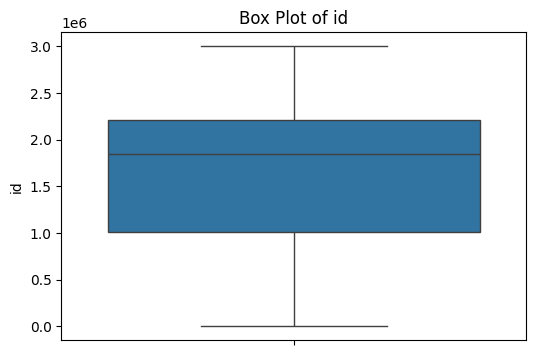

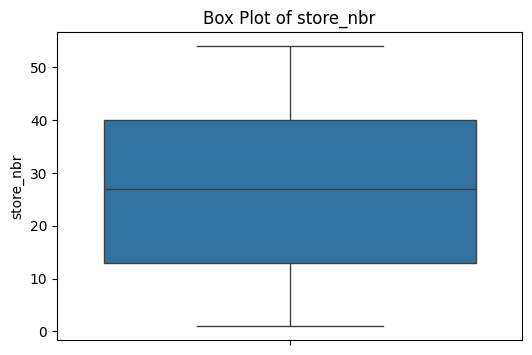

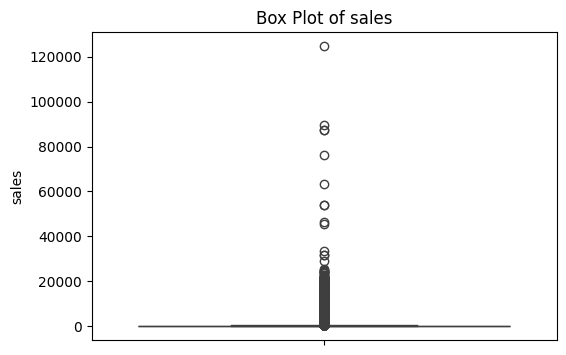

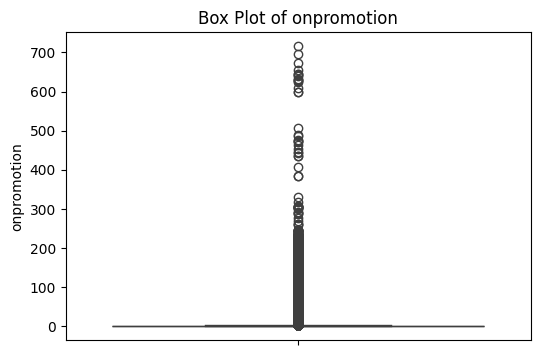

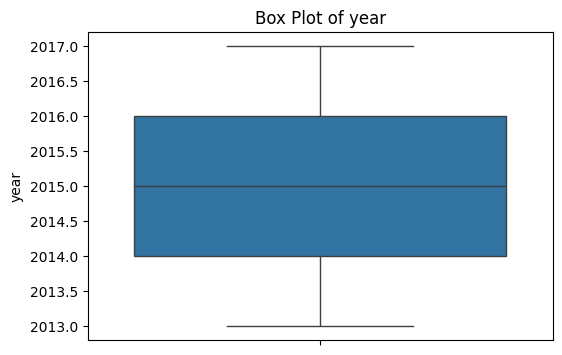

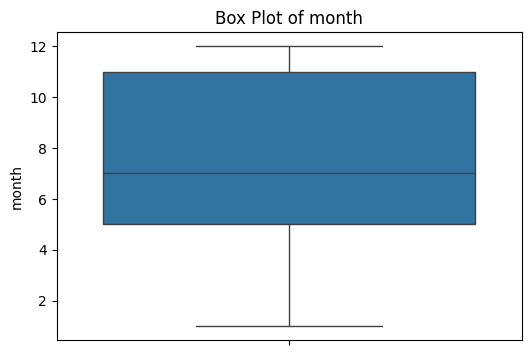

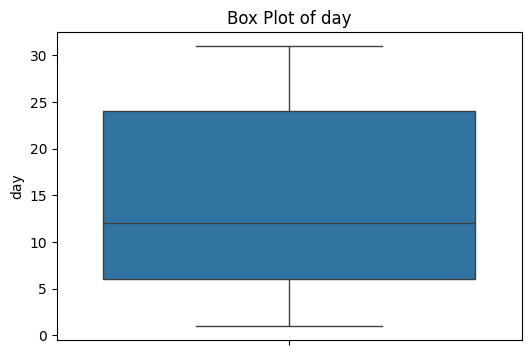

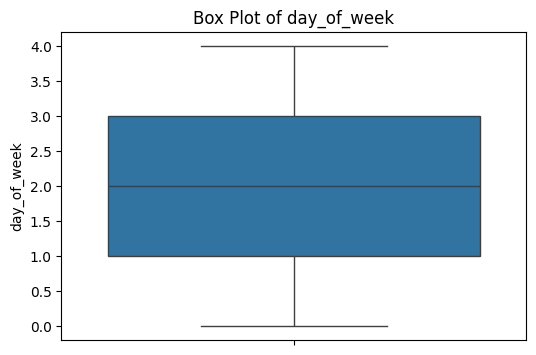

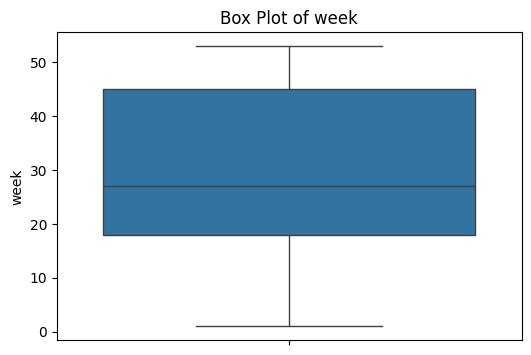

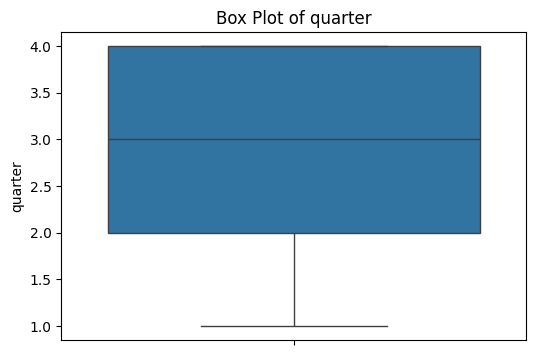

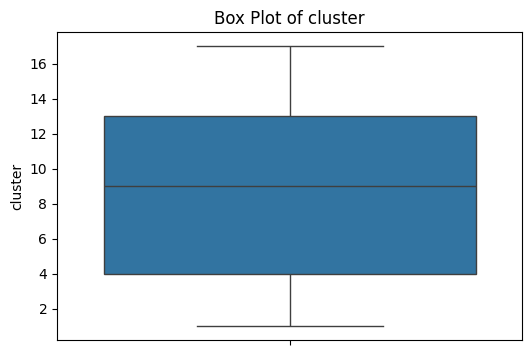

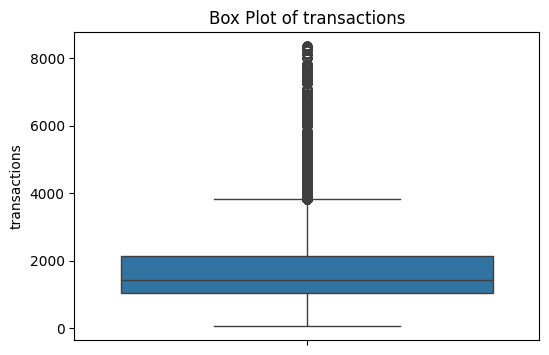

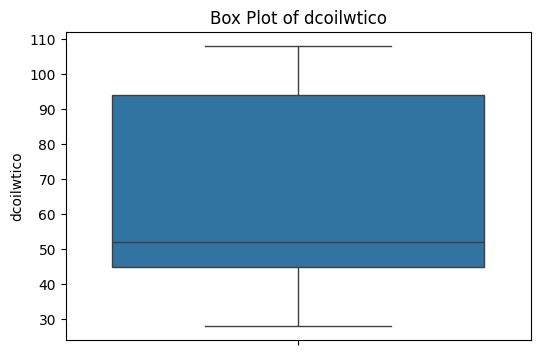

In [51]:
# Plotting box plots for each numerical column separately
for column in numerical_df.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=numerical_df[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

**General Observations:**
- Right-Skewness: Many columns, particularly sales, transactions, and onpromotion, show right-skewed distributions. This indicates that these columns have many low values and a few high-value outliers.
- Uniform Distributions: Columns like store_nbr, year, and month show more uniform distributions, suggesting consistent data collection practices.
- Trends Over Time: The date column shows a trend of increasing entries over the years, which could indicate growing data collection efforts or business activity over time.
- Multimodality: The dcoilwtico column's distribution suggests multiple peaks, indicating that the data may have several distinct value ranges or categories.
- outliers: there are outliers in transactions, onpromotion and sales columns

In [52]:
merged_data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year',
       'month', 'day', 'day_of_week', 'week', 'quarter', 'city', 'state',
       'store_type', 'cluster', 'transactions', 'holiday_type', 'locale',
       'locale_name', 'description', 'transferred', 'dcoilwtico'],
      dtype='object')

In [53]:
merged_data.shape

(322047, 23)

**BIVARIATE AND MULTIVARIATE ANALYSIS**

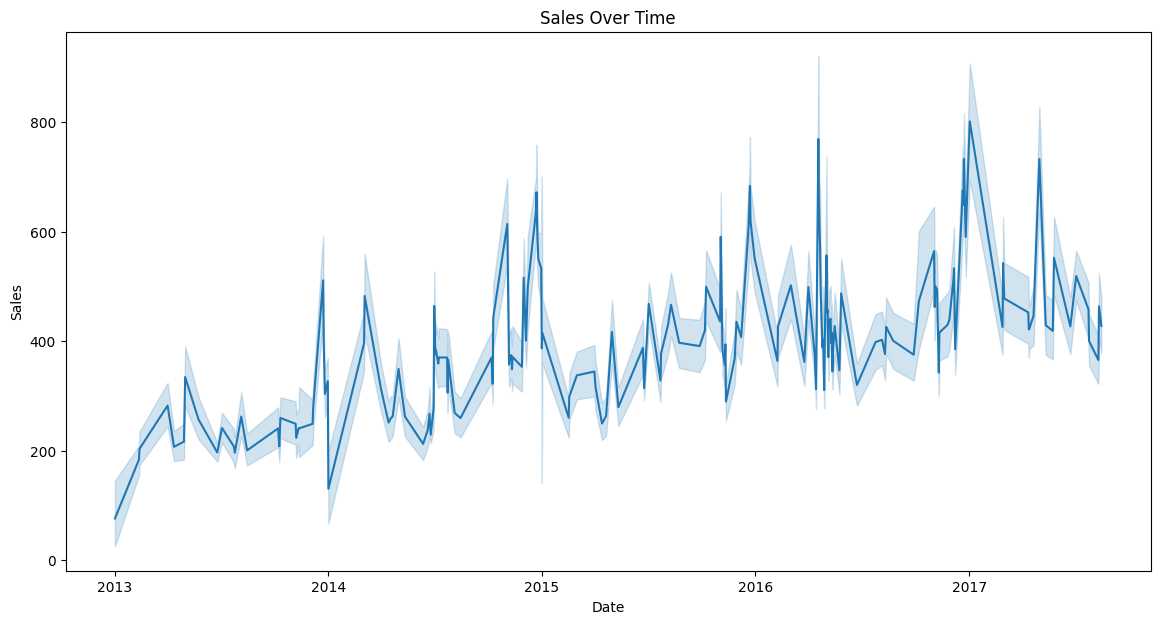

In [54]:
# Plot sales over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=merged_data, x='date', y='sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

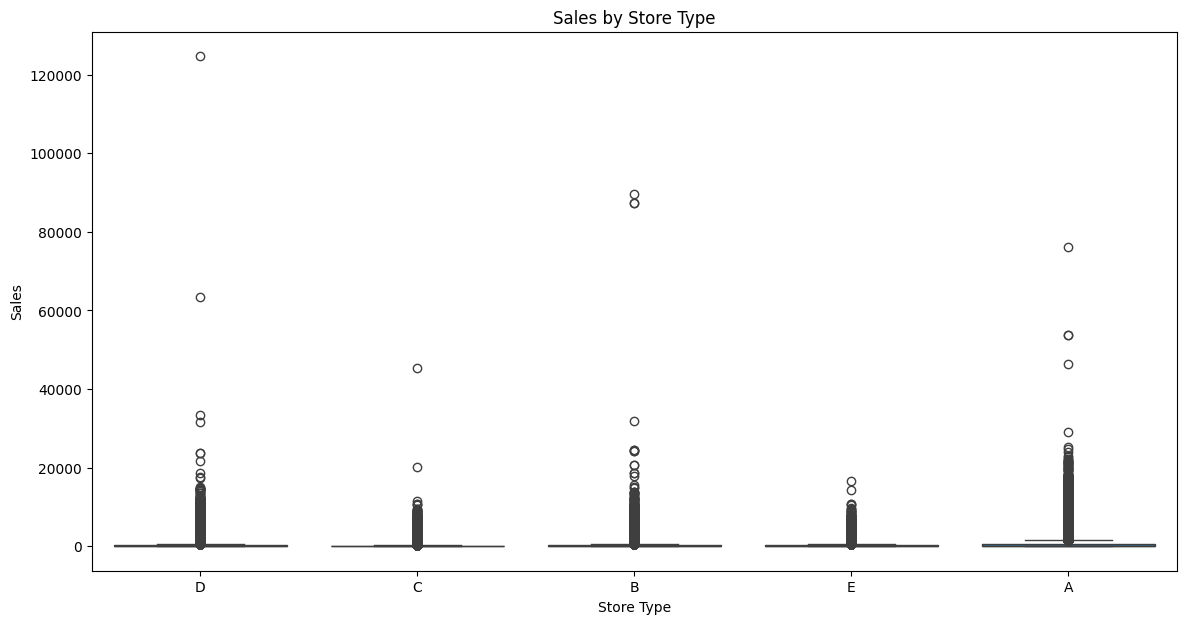

In [55]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=merged_data, x='store_type', y='sales')
plt.title('Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

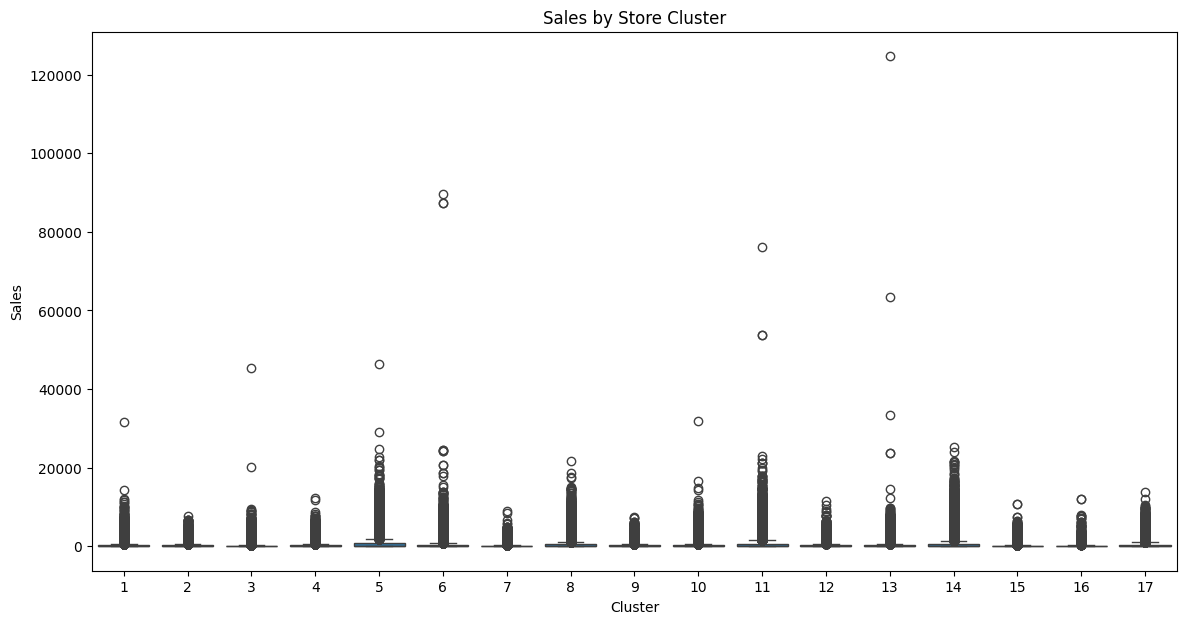

In [56]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=merged_data, x='cluster', y='sales')
plt.title('Sales by Store Cluster')
plt.xlabel('Cluster')
plt.ylabel('Sales')
plt.show()

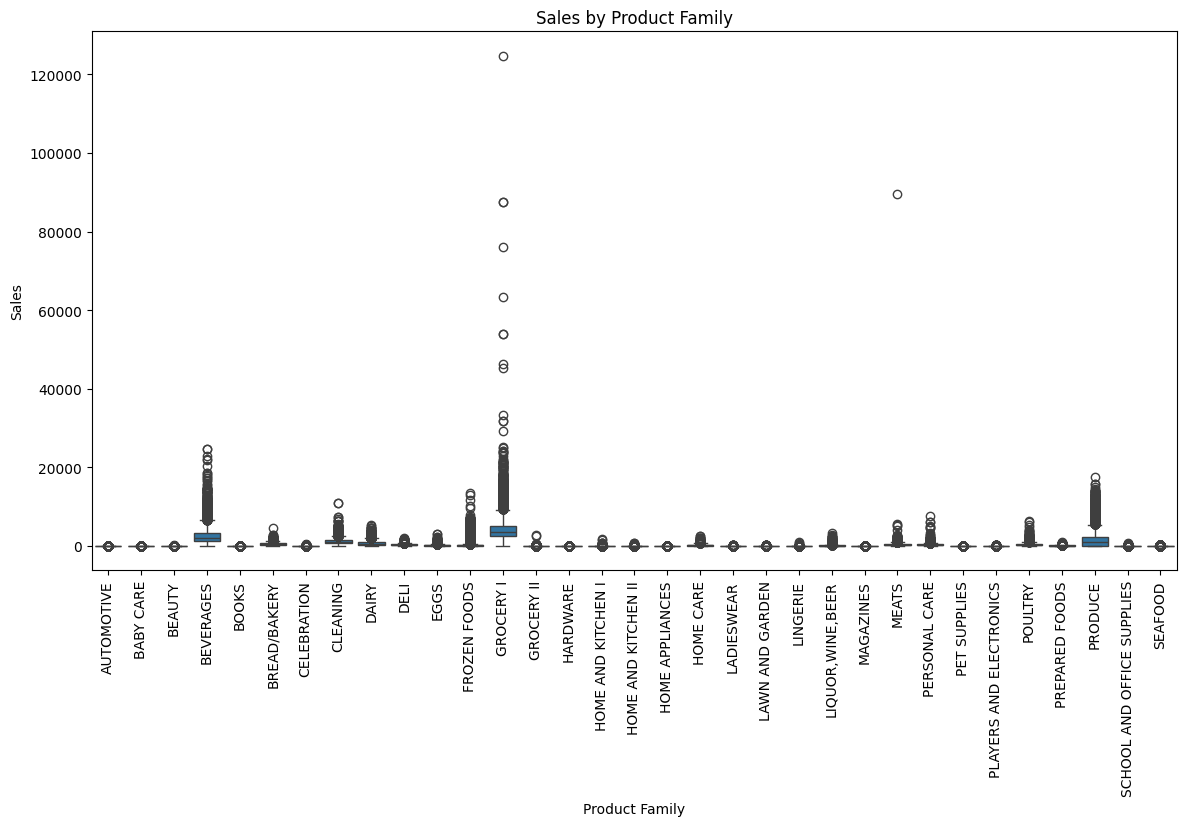

In [57]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=merged_data, x='family', y='sales')
plt.title('Sales by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()

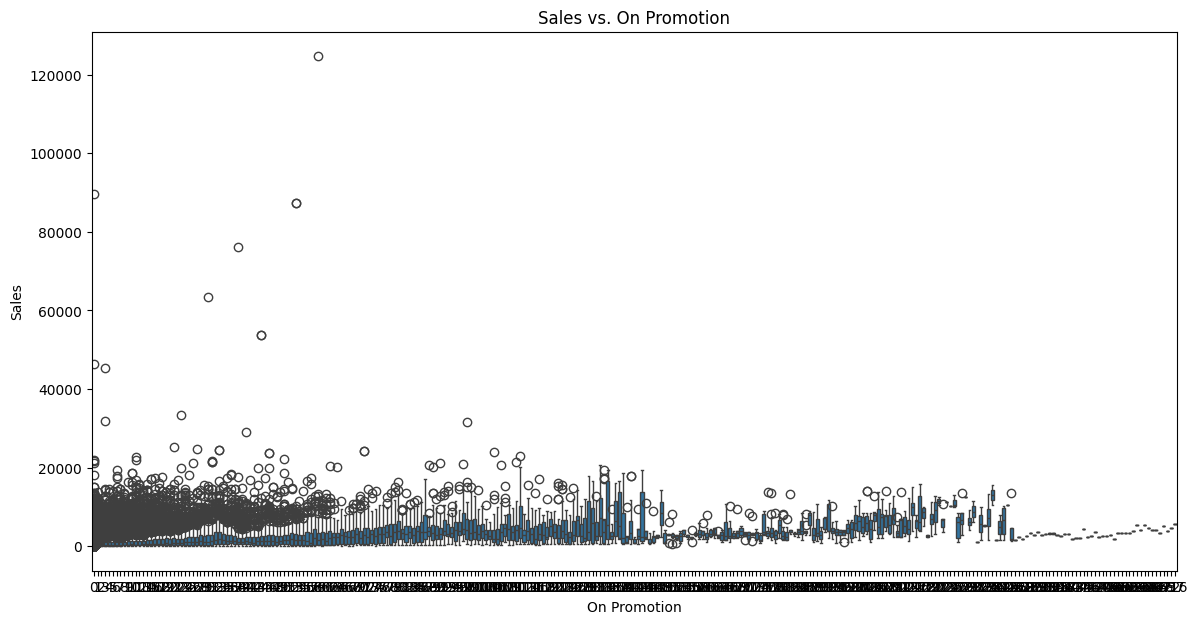

In [58]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=merged_data, x='onpromotion', y='sales')
plt.title('Sales vs. On Promotion')
plt.xlabel('On Promotion')
plt.ylabel('Sales')
plt.show()

## multivariate

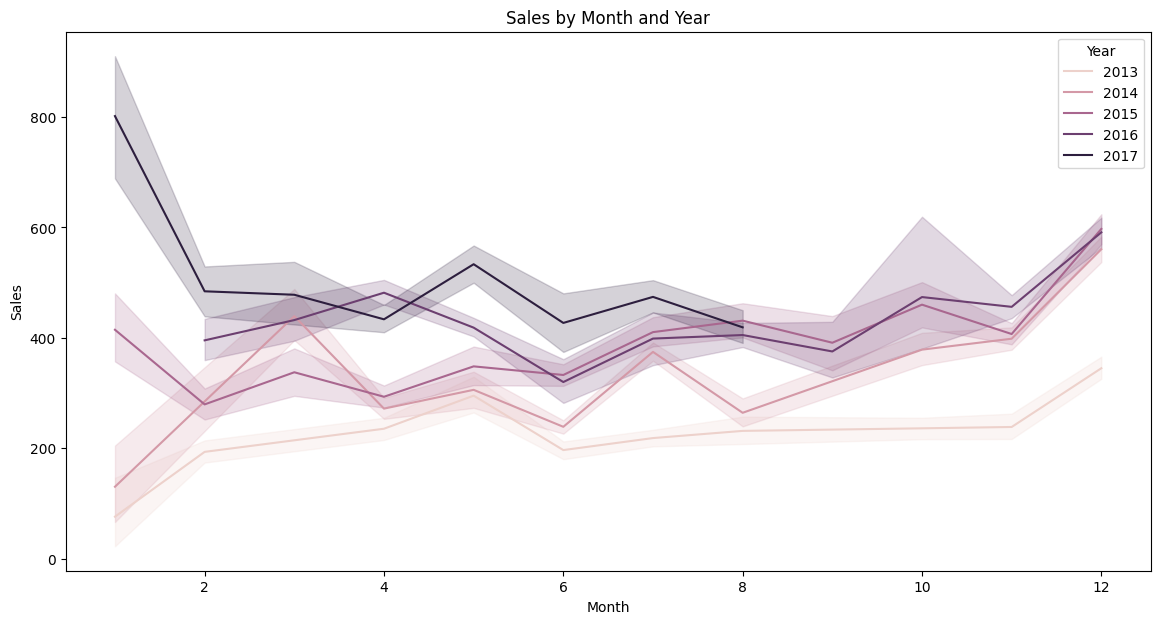

In [59]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=merged_data, x='month', y='sales', hue='year')
plt.title('Sales by Month and Year')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(title='Year')
plt.show()


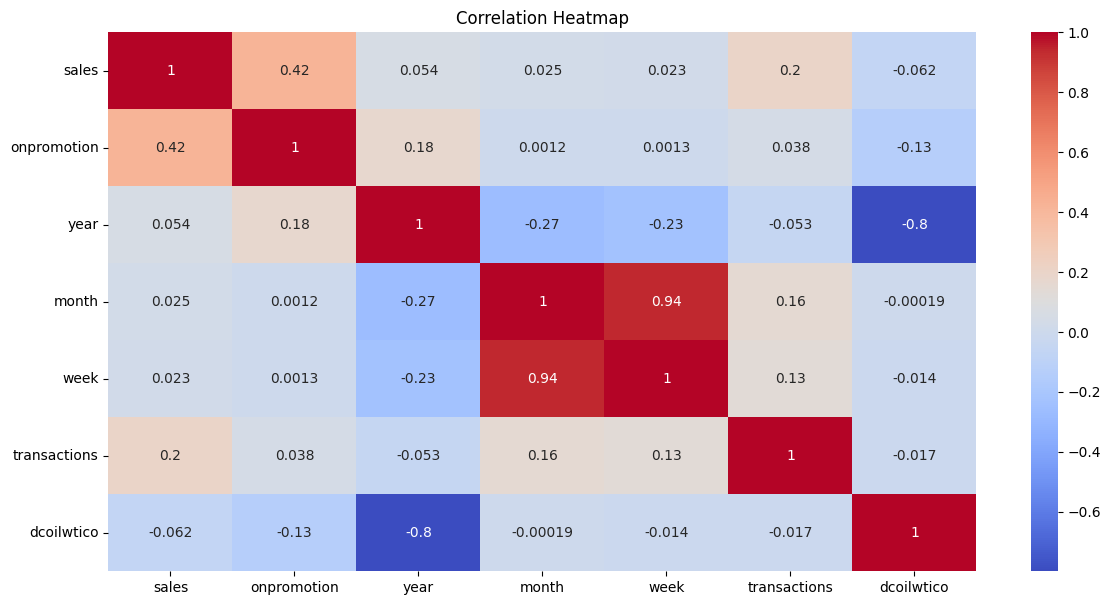

In [60]:
# Selecting relevant numerical columns
numerical_cols = ['sales', 'onpromotion', 'year', 'month', 'week', 'transactions', 'dcoilwtico']

plt.figure(figsize=(14, 7))
sns.heatmap(merged_data[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


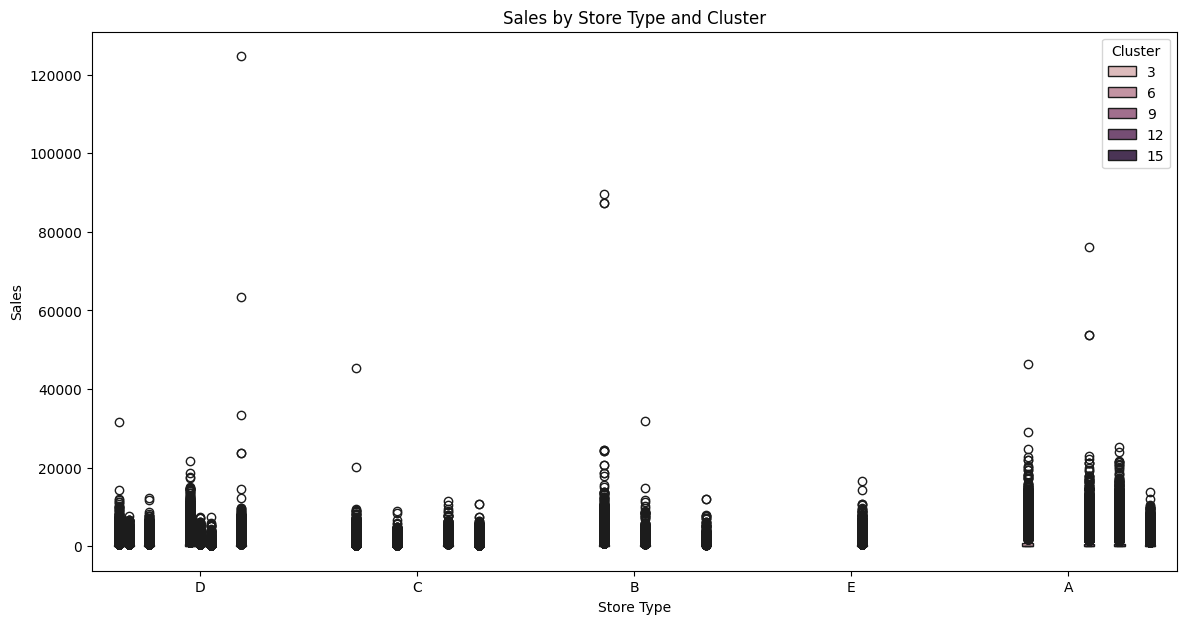

In [61]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=merged_data, x='store_type', y='sales', hue='cluster')
plt.title('Sales by Store Type and Cluster')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.legend(title='Cluster')
plt.show()


**Hypothesis Testing**

Hypothesis

- Null Hypothesis: Promotions do not have a significant effect on the sales of products.
- Alternative Hypothesis: Promotions have a significant effect on the sales of products. 

In [62]:
# Define if promotion is active (more than 0 items promoted)
merged_data['is_promotion_active'] = merged_data['onpromotion'] > 0

# Split the data into sales with promotions and without promotions
promotion_sales = merged_data[merged_data['is_promotion_active']]['sales']
no_promotion_sales = merged_data[~merged_data['is_promotion_active']]['sales']

# Perform a t-test to see if there's a significant difference in sales
t_stat, p_val = ttest_ind(promotion_sales, no_promotion_sales)

# Print results
print(f'T-statistic: {t_stat:.4f}')
print(f'P-value: {p_val:.4f}')

# Interpretation
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: Promotions have a significant effect on sales.")
else:
    print("Fail to reject the null hypothesis: Promotions do not have a significant effect on sales.")

T-statistic: 208.3956
P-value: 0.0000
Reject the null hypothesis: Promotions have a significant effect on sales.


**Analytical Questions**

1. Is the train dataset complete (has all the required dates)?

In [63]:
# Generate the complete date range
complete_date_range = pd.date_range(start=train_data['date'].min(), end=train_data['date'].max())

# Check for missing dates
missing_dates = complete_date_range.difference(train_data['date'].unique())

# Output the results
print(f"Minimum date in the dataset: {train_data['date'].min()}")
print(f"Maximum date in the dataset: {train_data['date'].max()}")
print(f"Number of missing dates: {len(missing_dates)}")
print(f"Missing dates: {missing_dates}")

Minimum date in the dataset: 2013-01-01 00:00:00
Maximum date in the dataset: 2017-08-15 00:00:00
Number of missing dates: 4
Missing dates: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

In [64]:
# Group the data by year and date, and sum the sales for each date
sales_per_day = merged_data.groupby(['year', 'date'])['sales'].sum().reset_index()

# Exclude days with zero sales (assuming these are the days the store was closed)
sales_per_day = sales_per_day[sales_per_day['sales'] > 0]

# Find the dates with the lowest and highest sales for each year
lowest_sales = sales_per_day.loc[sales_per_day.groupby('year')['sales'].idxmin()]
highest_sales = sales_per_day.loc[sales_per_day.groupby('year')['sales'].idxmax()]

# Display the results
print("Dates with the lowest sales for each year:")
print(lowest_sales)
print("\nDates with the highest sales for each year:")
print(highest_sales)

Dates with the lowest sales for each year:
     year       date          sales
0    2013 2013-01-01    2511.618999
28   2014 2014-01-01    8602.065404
70   2015 2015-01-01   12773.616980
121  2016 2016-04-28  543339.849013
176  2017 2017-08-10  651386.911970

Dates with the highest sales for each year:
     year       date         sales
8    2013 2013-06-25  9.153586e+05
65   2014 2014-12-22  2.016287e+06
102  2015 2015-12-22  2.283724e+06
157  2016 2016-12-22  2.271699e+06
173  2017 2017-07-03  1.850287e+06


3. Compare the sales for each month across the years and determine which month of which year had the highest sales.

In [65]:
# Group the data by year and month, and sum the sales for each month
monthly_sales = merged_data.groupby(['year', 'month'])['sales'].sum().reset_index()

# Find the month with the highest sales
highest_sales_month = monthly_sales.loc[monthly_sales['sales'].idxmax()]

# Display the results
print("Monthly sales comparison across the years:")
print(monthly_sales)
print("\nMonth with the highest sales:")
print(highest_sales_month)

Monthly sales comparison across the years:
    year  month         sales
0   2013      1  2.511619e+03
1   2013      2  5.874284e+05
2   2013      4  1.072007e+06
3   2013      5  9.063639e+05
4   2013      6  9.153586e+05
5   2013      7  1.672679e+06
6   2013      8  7.180770e+05
7   2013     10  1.098830e+06
8   2013     11  1.480086e+06
9   2013     12  3.210593e+06
10  2014      1  8.602065e+03
11  2014      3  1.362904e+06
12  2014      4  1.659536e+06
13  2014      5  9.286327e+05
14  2014      6  2.964238e+06
15  2014      7  5.253892e+06
16  2014      8  8.198293e+05
17  2014     10  1.799401e+06
18  2014     11  4.418237e+06
19  2014     12  8.878967e+06
20  2015      1  6.705370e+05
21  2015      2  9.038290e+05
22  2015      3  5.460378e+05
23  2015      4  1.897162e+06
24  2015      5  1.126672e+06
25  2015      6  2.196425e+06
26  2015      7  2.722302e+06
27  2015      8  2.191401e+06
28  2015      9  6.712611e+05
29  2015     10  1.594497e+06
30  2015     11  5.694471e+

4. Did the earthquake impact sales?

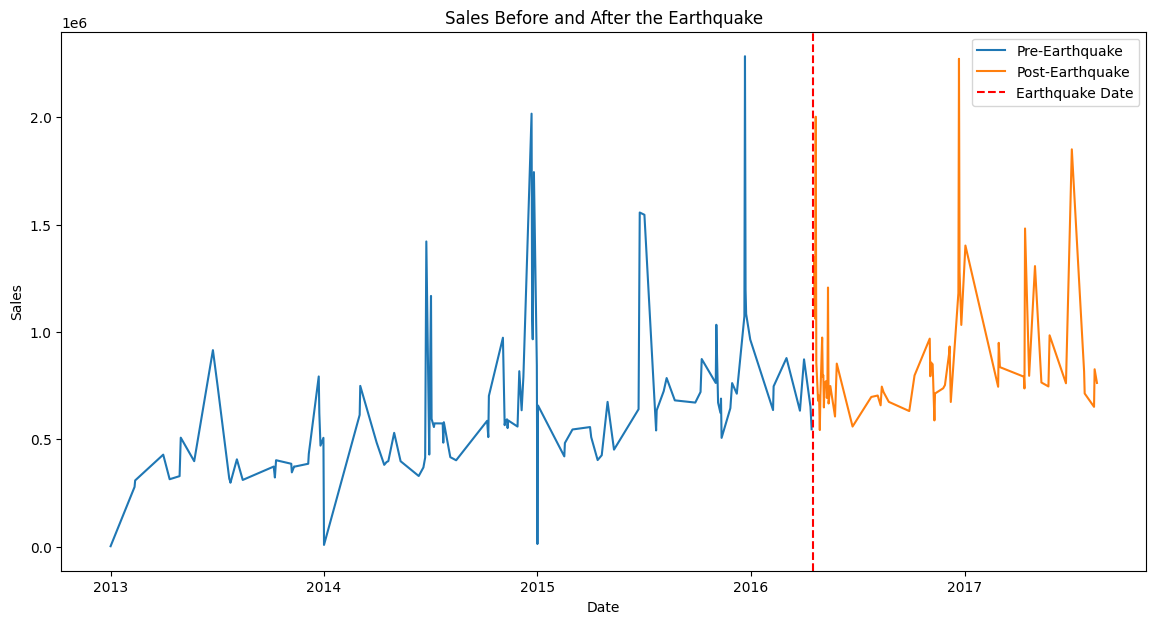

Average sales before the earthquake: 639405.18
Average sales after the earthquake: 888208.89


In [66]:
# Define the earthquake date
earthquake_date = pd.to_datetime('2016-04-16')

# Create a flag for pre- and post-earthquake periods
merged_data['earthquake_impact'] = merged_data['date'].apply(lambda x: 'Post-Earthquake' if x >= earthquake_date else 'Pre-Earthquake')

# Group the data by date and sum the sales for each date
daily_sales = merged_data.groupby('date')['sales'].sum().reset_index()

# Merge with earthquake impact flag
daily_sales = daily_sales.merge(merged_data[['date', 'earthquake_impact']].drop_duplicates(), on='date')

# Plot sales before and after the earthquake
plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_sales, x='date', y='sales', hue='earthquake_impact')
plt.axvline(x=earthquake_date, color='r', linestyle='--', label='Earthquake Date')
plt.title('Sales Before and After the Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate average sales before and after the earthquake
pre_earthquake_sales = daily_sales[daily_sales['earthquake_impact'] == 'Pre-Earthquake']['sales'].mean()
post_earthquake_sales = daily_sales[daily_sales['earthquake_impact'] == 'Post-Earthquake']['sales'].mean()

print(f"Average sales before the earthquake: {pre_earthquake_sales:.2f}")
print(f"Average sales after the earthquake: {post_earthquake_sales:.2f}")

5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

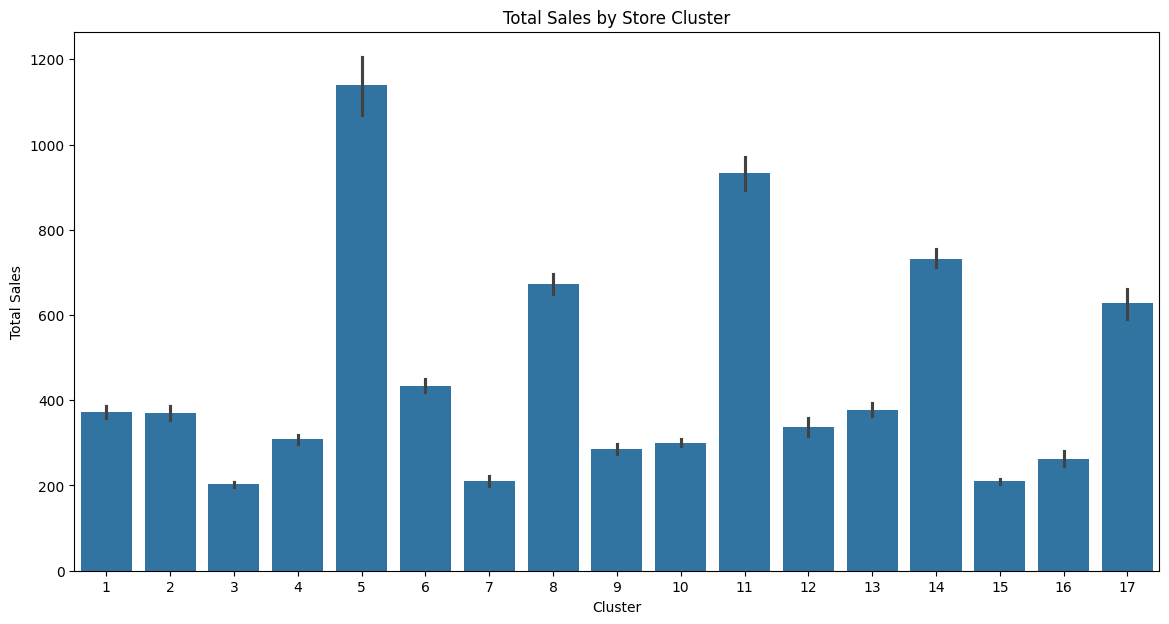

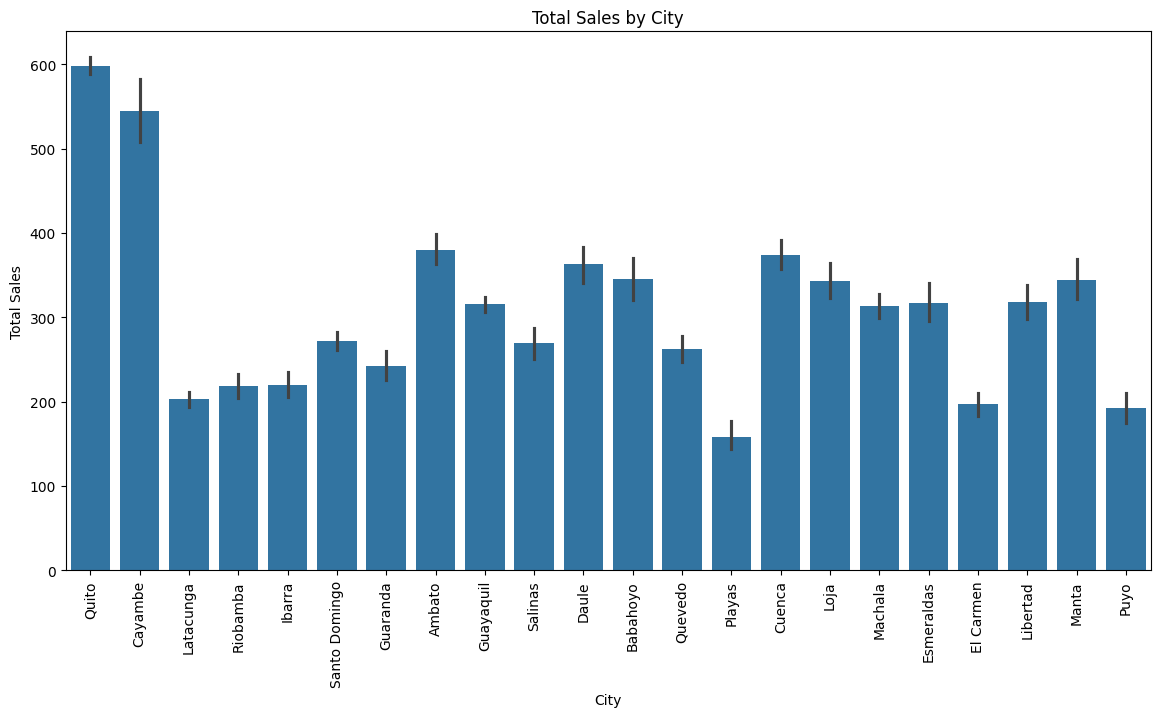

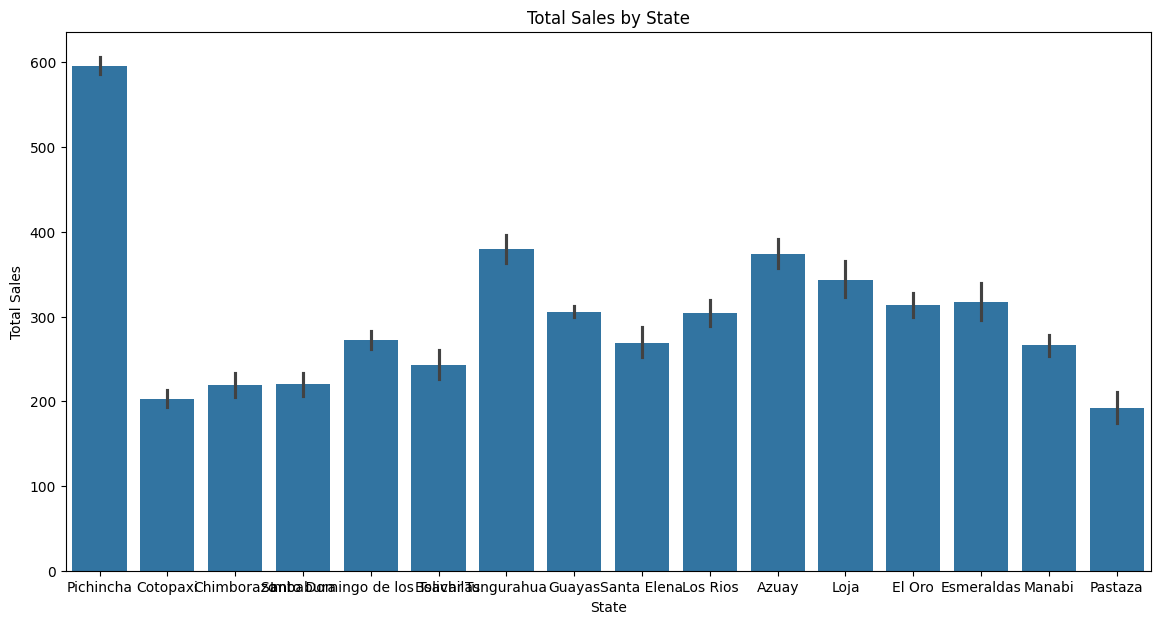

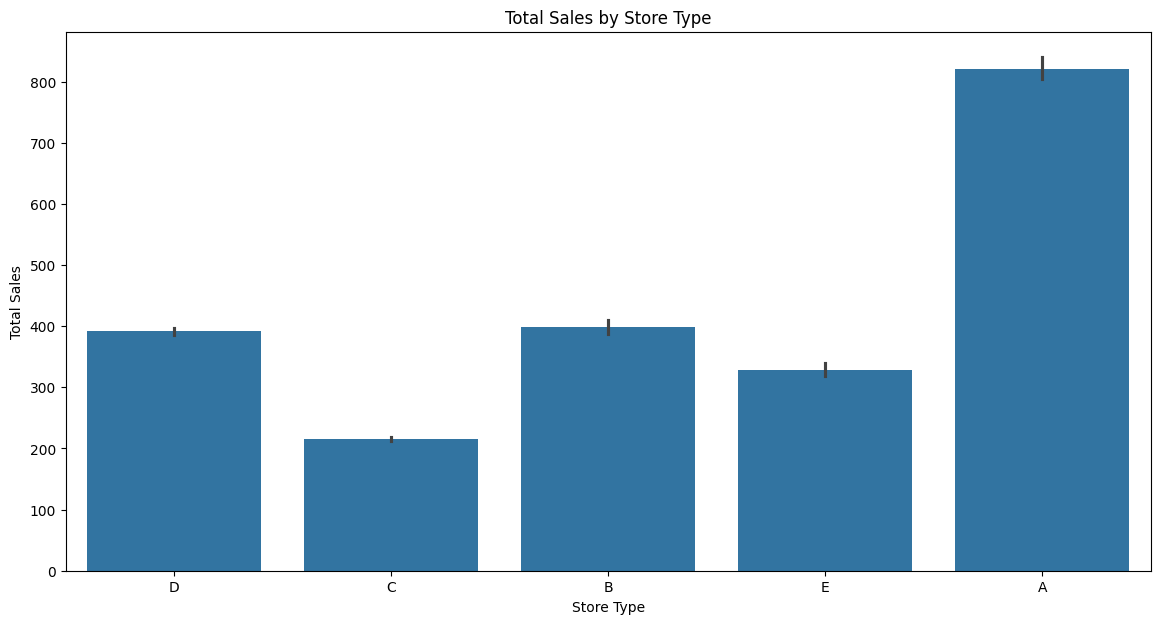

Top 10 stores by total sales:
    store_nbr         sales
43         44  7.297347e+06
44         45  6.646578e+06
46         47  6.052432e+06
2           3  5.985505e+06
48         49  5.388407e+06
45         46  5.016086e+06
47         48  4.247941e+06
50         51  4.020780e+06
7           8  3.571102e+06
10         11  3.485479e+06


In [67]:
# Plot sales by cluster
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='cluster', y='sales')
plt.title('Total Sales by Store Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.show()

# Plot sales by city
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='city', y='sales')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

# Plot sales by state
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='state', y='sales')
plt.title('Total Sales by State')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.show()

# Plot sales by store type
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='store_type', y='sales')
plt.title('Total Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.show()

# Display top stores in terms of total sales
top_stores = merged_data.groupby('store_nbr')['sales'].sum().reset_index().sort_values(by='sales', ascending=False).head(10)
print("Top 10 stores by total sales:")
print(top_stores)

6. Are sales affected by promotions, oil prices and holidays?

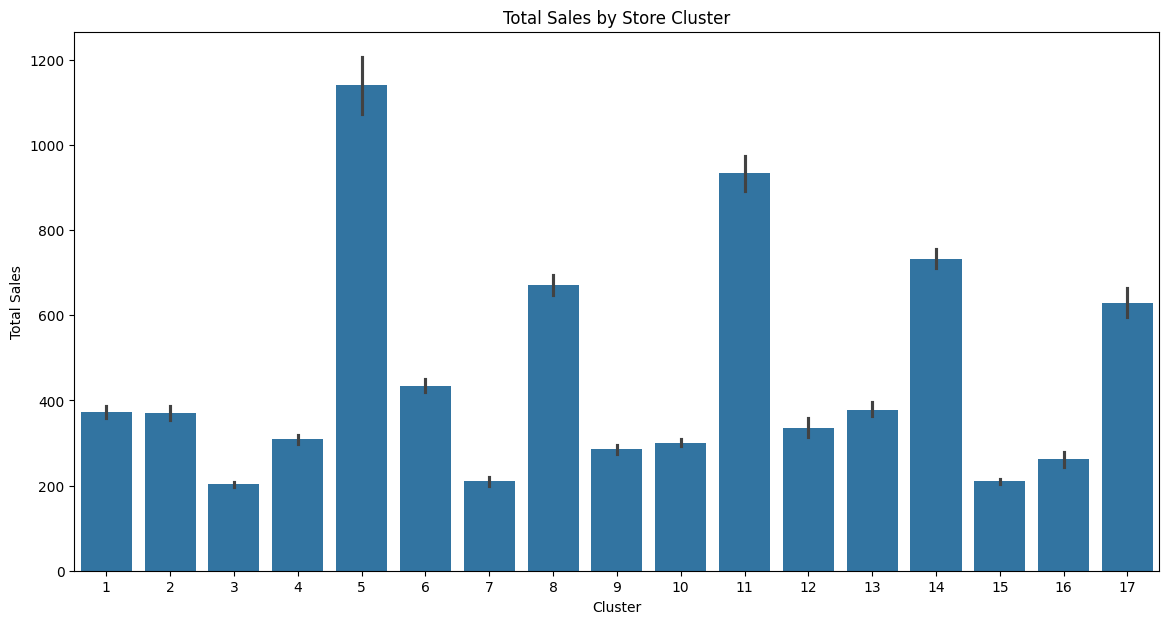

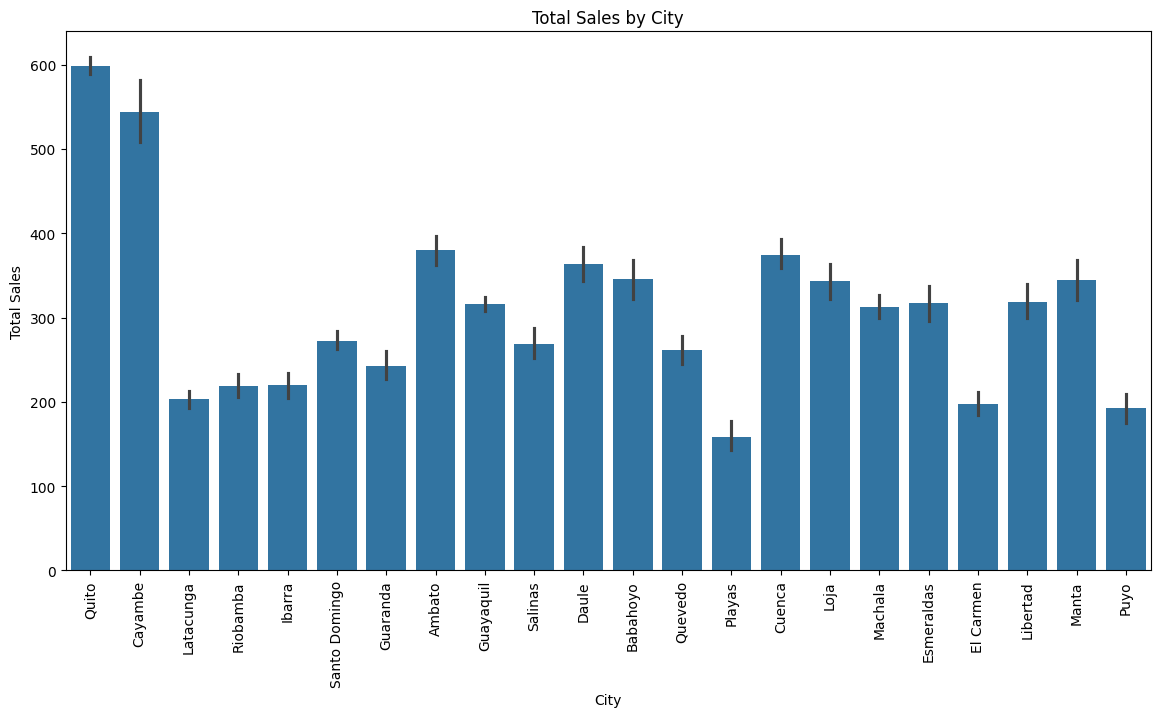

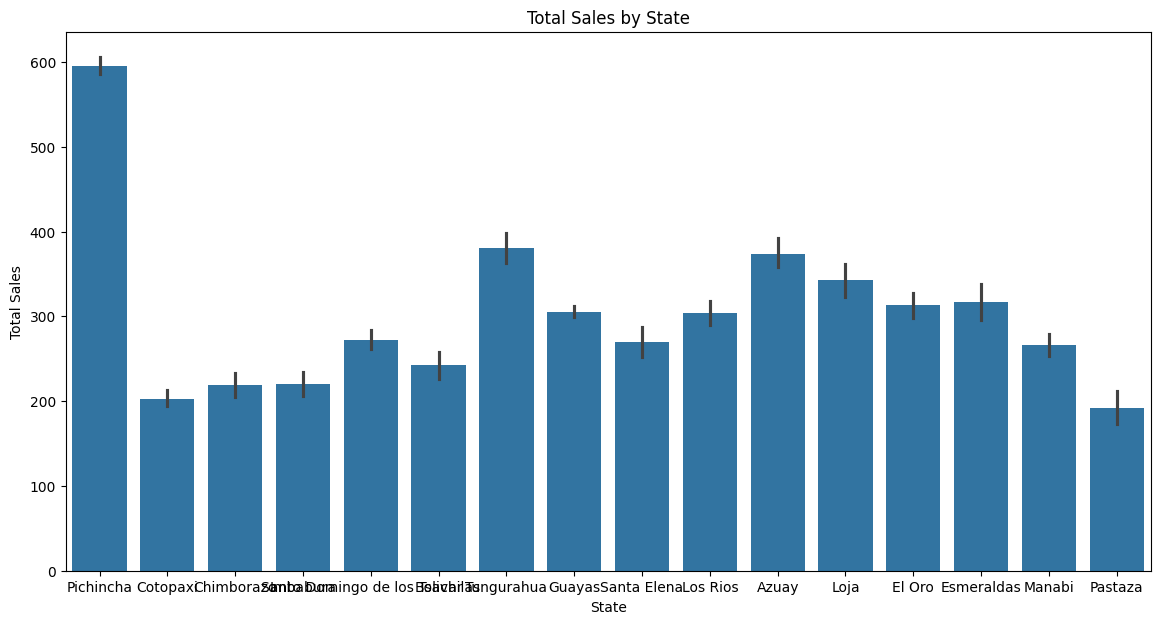

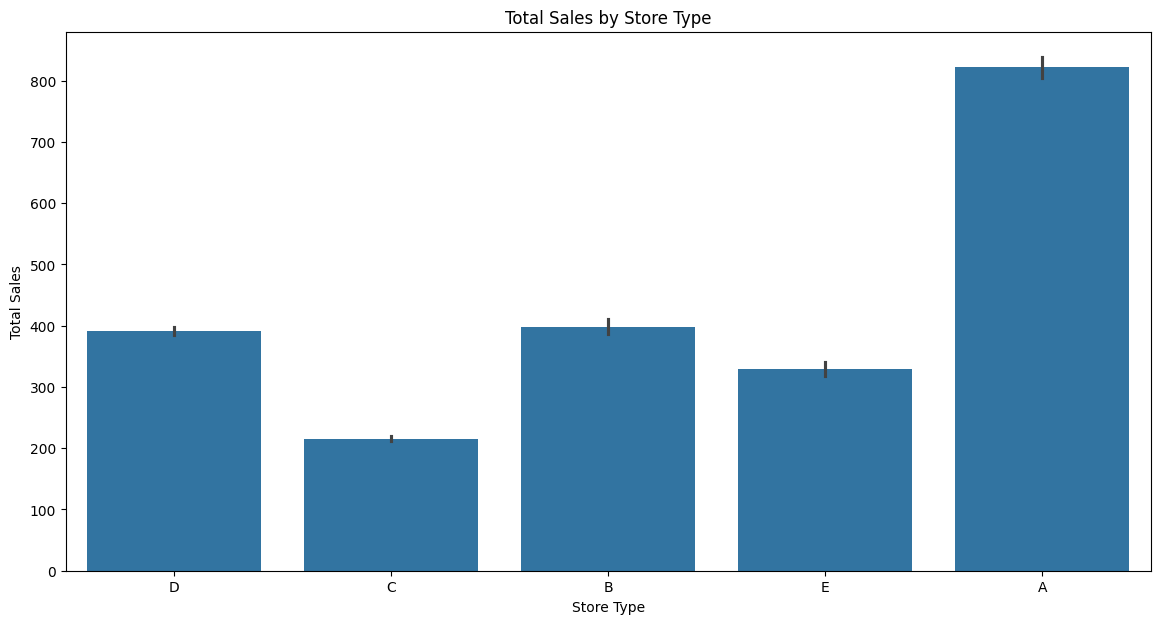

Top 10 stores by total sales:
    store_nbr         sales
43         44  7.297347e+06
44         45  6.646578e+06
46         47  6.052432e+06
2           3  5.985505e+06
48         49  5.388407e+06
45         46  5.016086e+06
47         48  4.247941e+06
50         51  4.020780e+06
7           8  3.571102e+06
10         11  3.485479e+06


In [68]:
# Plot sales by cluster
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='cluster', y='sales')
plt.title('Total Sales by Store Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.show()

# Plot sales by city
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='city', y='sales')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

# Plot sales by state
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='state', y='sales')
plt.title('Total Sales by State')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.show()

# Plot sales by store type
plt.figure(figsize=(14, 7))
sns.barplot(data=merged_data, x='store_type', y='sales')
plt.title('Total Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.show()

# Display top stores in terms of total sales
top_stores = merged_data.groupby('store_nbr')['sales'].sum().reset_index().sort_values(by='sales', ascending=False).head(10)
print("Top 10 stores by total sales:")
print(top_stores)

7. What analysis can we get from the date and its extractable features?

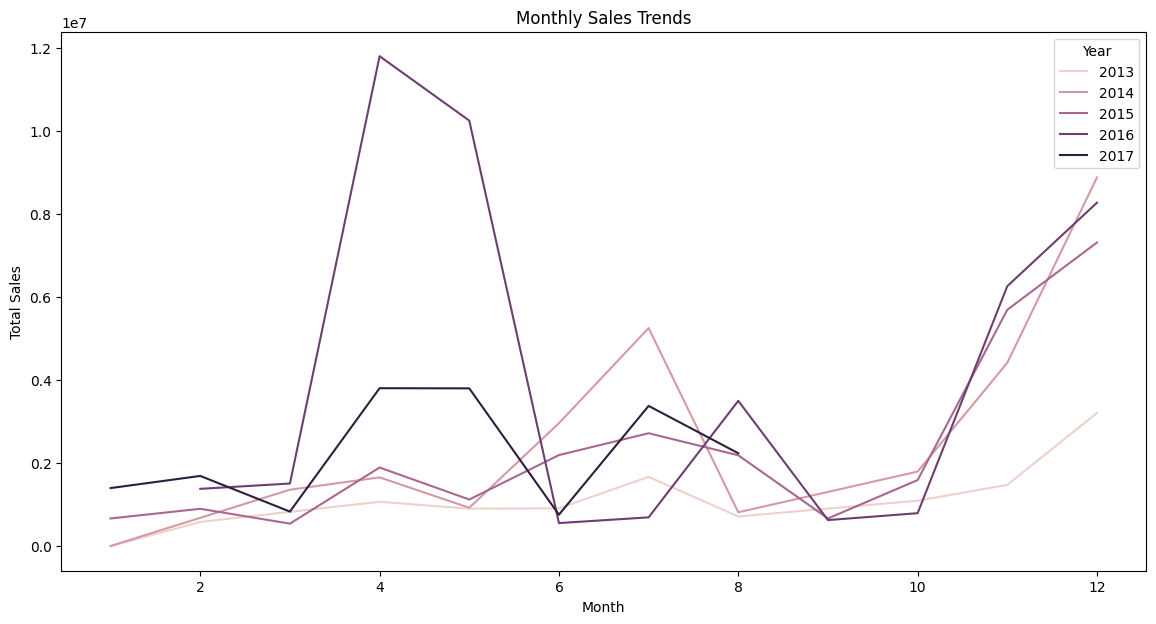

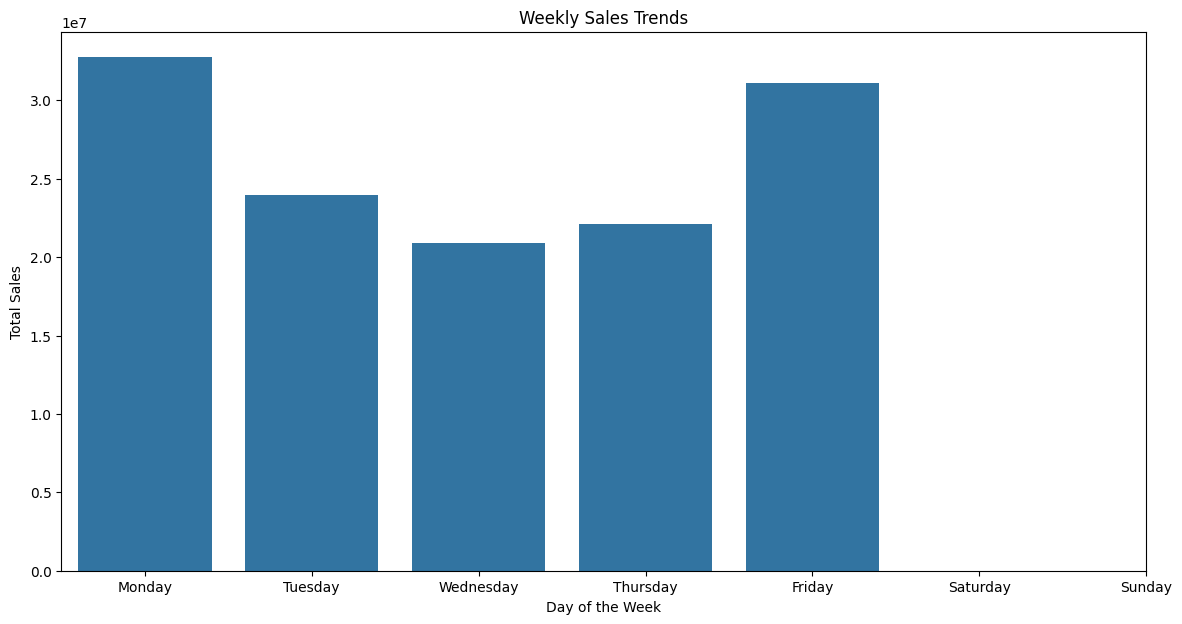

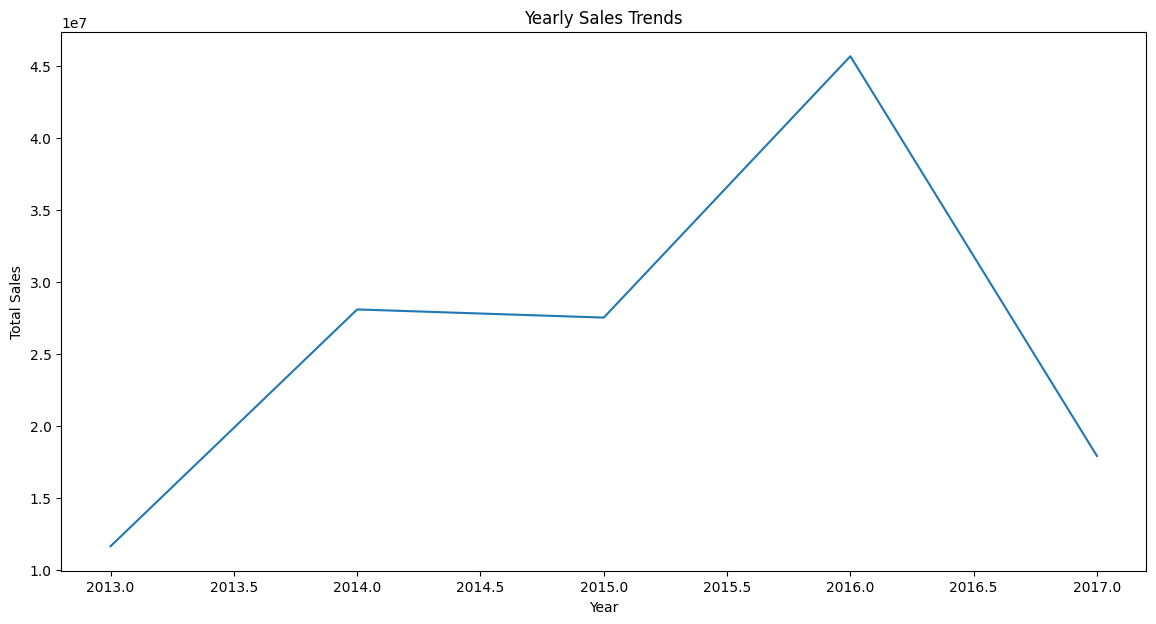

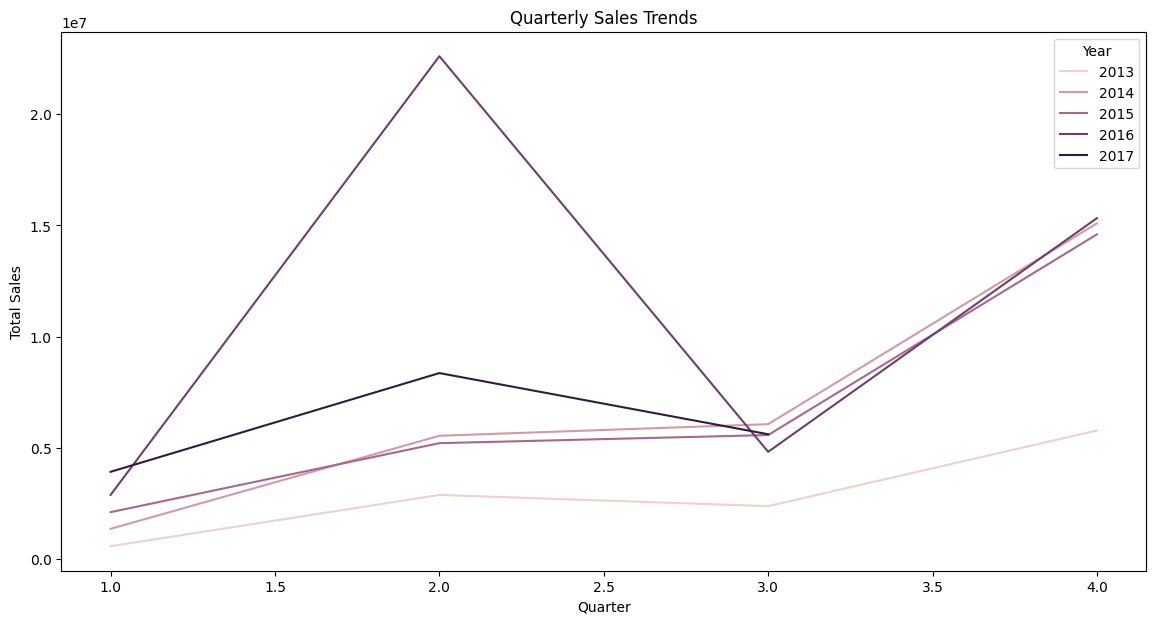

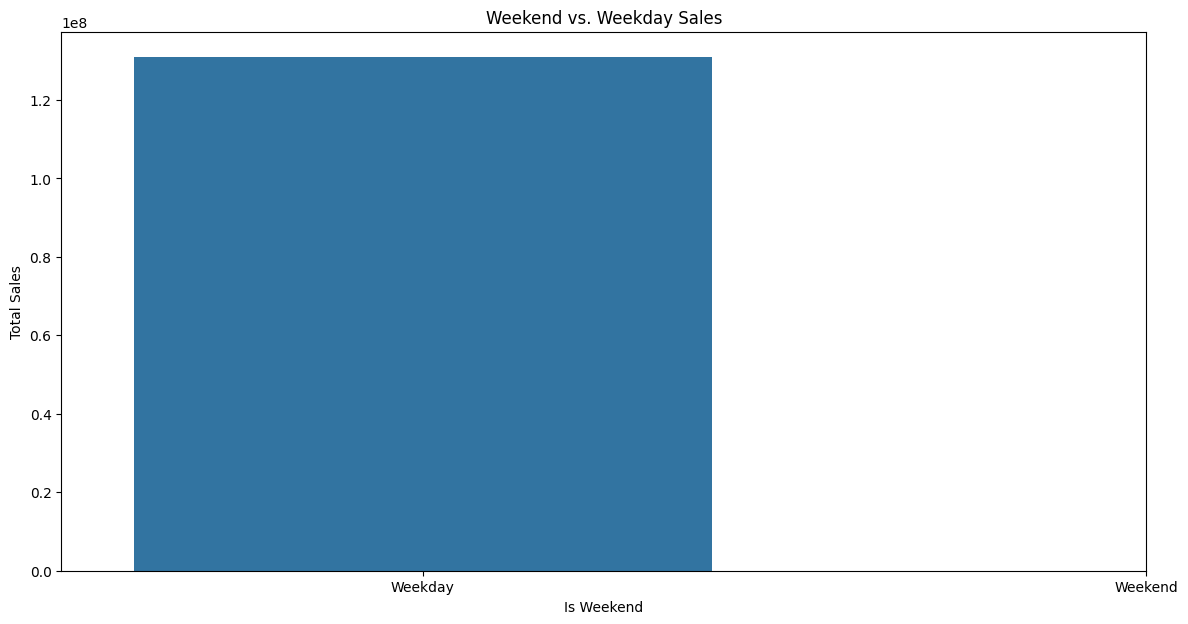

In [69]:
# Monthly Sales Trends
monthly_sales = merged_data.groupby(['year', 'month'])['sales'].sum().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_sales, x='month', y='sales', hue='year')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Year')
plt.show()

# Weekly Sales Trends
weekly_sales = merged_data.groupby(['day_of_week'])['sales'].sum().reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(data=weekly_sales, x='day_of_week', y='sales')
plt.title('Weekly Sales Trends')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

# Yearly Sales Trends
yearly_sales = merged_data.groupby('year')['sales'].sum().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=yearly_sales, x='year', y='sales')
plt.title('Yearly Sales Trends')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.show()

# Quarterly Sales Trends
quarterly_sales = merged_data.groupby(['year', 'quarter'])['sales'].sum().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=quarterly_sales, x='quarter', y='sales', hue='year')
plt.title('Quarterly Sales Trends')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.legend(title='Year')
plt.show()

# Weekend vs. Weekday Sales
merged_data['is_weekend'] = merged_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
weekend_sales = merged_data.groupby('is_weekend')['sales'].sum().reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(data=weekend_sales, x='is_weekend', y='sales')
plt.title('Weekend vs. Weekday Sales')
plt.xlabel('Is Weekend')
plt.ylabel('Total Sales')
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'])
plt.show()

8. Which product family and stores did the promotions affect.

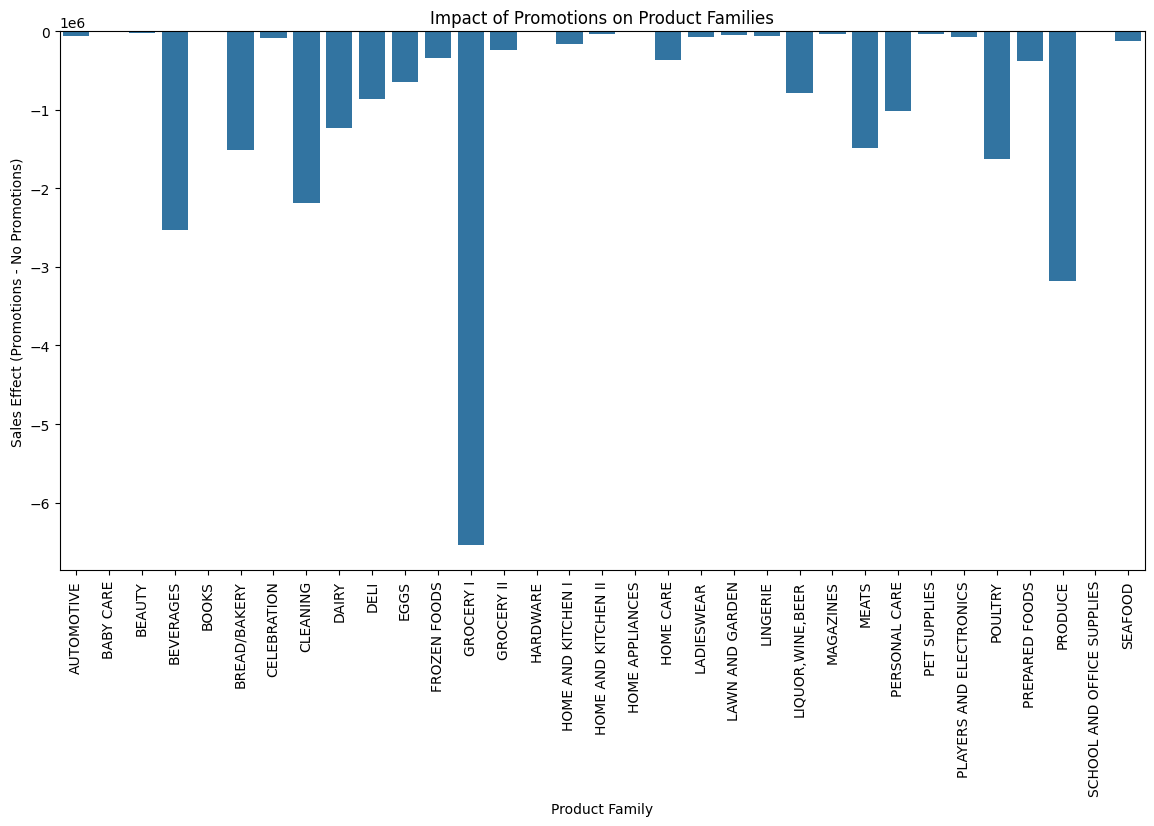

In [70]:


# Analyze the impact of promotions on product families
product_family_sales = merged_data.groupby(['family', 'onpromotion'])['sales'].sum().reset_index()

# Create a pivot table to compare sales with and without promotions for each product family
pivot_family = merged_data.pivot_table(index='family', columns='onpromotion', values='sales', aggfunc='sum', fill_value=0)
pivot_family['promo_effect'] = pivot_family[1] - pivot_family[0]

# Plot sales by product family
plt.figure(figsize=(14, 7))
sns.barplot(x=pivot_family.index, y=pivot_family['promo_effect'])
plt.title('Impact of Promotions on Product Families')
plt.xlabel('Product Family')
plt.ylabel('Sales Effect (Promotions - No Promotions)')
plt.xticks(rotation=90)
plt.show()



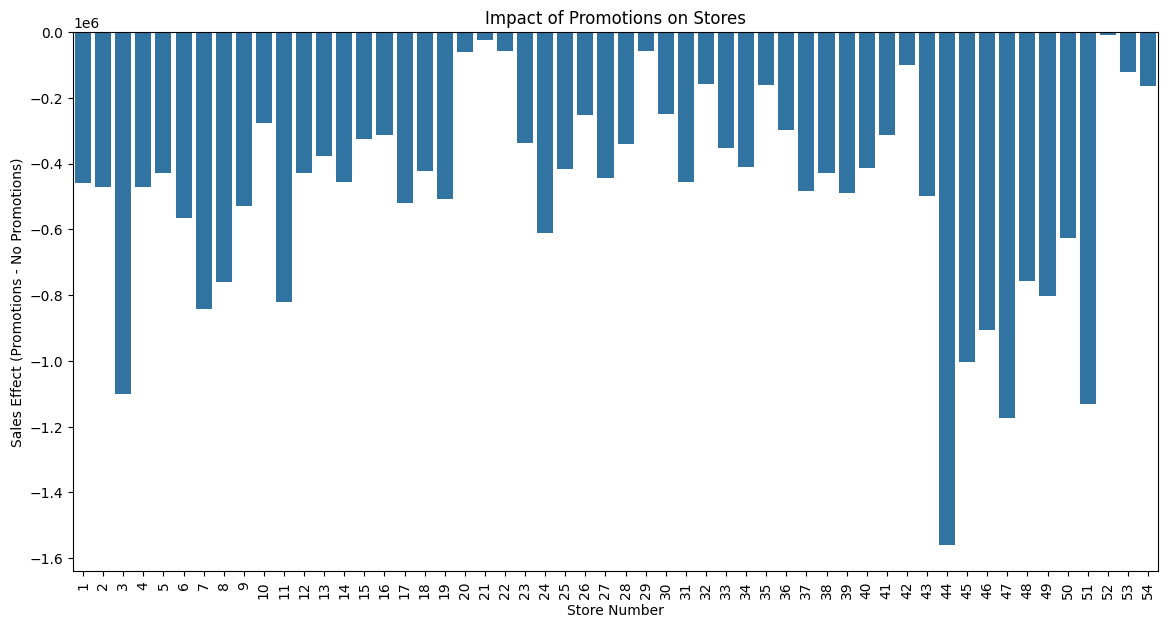

In [71]:
# Aggregate sales by store and promotion status
store_sales = merged_data.groupby(['store_nbr', 'onpromotion'])['sales'].sum().reset_index()

# Create a pivot table to compare sales with and without promotions for each store
pivot_store = merged_data.pivot_table(index='store_nbr', columns='onpromotion', values='sales', aggfunc='sum', fill_value=0)
pivot_store['promo_effect'] = pivot_store[1] - pivot_store[0]

# Plot sales by store
plt.figure(figsize=(14, 7))
sns.barplot(x=pivot_store.index, y=pivot_store['promo_effect'])
plt.title('Impact of Promotions on Stores')
plt.xlabel('Store Number')
plt.ylabel('Sales Effect (Promotions - No Promotions)')
plt.xticks(rotation=90)
plt.show()



**MODELLING AND EVALUATION**